In [29]:
import msprime

In [30]:
demography = msprime.Demography.from_tree_sequence(ts)

In [31]:
demography

id,name,description,initial_size,growth_rate,default_sampling_time,extra_metadata
0,pop_0,,0.0,0,0,{}
1,pop_1,,0.0,0,0,{}
2,pop_2,,0.0,0,0,{}
3,pop_3,,0.0,0,0,{}
4,pop_4,,0.0,0,0,{}
5,pop_5,,0.0,0,0,{}
6,pop_6,,0.0,0,0,{}
7,pop_7,,0.0,0,0,{}
8,pop_8,,0.0,0,0,{}
9,pop_9,,0.0,0,0,{}


In [32]:
ts.metadata['SLiM']['generation']

18967

# Detecting true introgressed tracts from simulated tree sequences

This notebook works on a tree sequence file saved by a [slendr](http://www.slendr.net) simulation framework from a model defined in `introgression.Rmd`.

In [1]:
ls /projects/racimolab/people/gsd818/arcIntro/introgression-sims/segment_length_200kb/modelA/results/

eigenstrat.geno      f4_result_ratio_time.png  nea1A
eigenstrat.ind       f4_result_stats.png       nodes.tsv
eigenstrat.snp       modelA_output_ts.trees    output.vcf.gz
f4_result_ratio.png  modelA_tracts.tsv.gz


In [2]:
trees_file = "/projects/racimolab/people/gsd818/arcIntro/introgression-sims/segment_length_200kb/modelA/results/modelA_output_ts.trees"

In [3]:
import random
from itertools import chain
from collections import defaultdict

import tskit
import pyslim
import pandas
import numpy
import matplotlib.pyplot as plt
import tqdm.notebook
from IPython.display import display, SVG

random.seed(314159265)

In [4]:
populations = pandas.read_table("/projects/racimolab/people/gsd818/arcIntro/introgression-sims/segment_length_200kb/modelA/model/populations.tsv")

Load the complete tree sequence output:

In [5]:
ts = pyslim.load(trees_file)
ts

/projects/racimolab/people/krd114/.conda/envs/introgression-sims/lib/python3.9/site-packages/pyslim/slim_tree_sequence.py:1016: UserWarning: This is a version 0.6 SLiM tree sequence. When you write this out, it will be converted to version 0.7.
  warnings.warn("This is a version {} SLiM tree sequence.".format(file_version) +


Get nodes (chromosomes) of remembered individuals and simplify the tree sequence only to those nodes to make it simpler:

In [6]:
remembered_nodes = list(chain.from_iterable(
    ind.nodes for ind in ts.individuals()
    if ind.flags & pyslim.INDIVIDUAL_REMEMBERED
))

ts = ts.simplify(remembered_nodes, filter_populations=False)

ts

In [7]:
for p in ts.populations():
    print(p.id)

0
1
2
3
4
5
6
7
8
9
10
11


In [8]:
populations

,pop,parent,N,tsplit_gen,tsplit_orig,tremove_gen,tremove_orig,pop_id,parent_id
0,archaic,ancestor,3000,1,550000,-1,-1,0,-1
1,AMH,ancestor,10000,1,550000,-1,-1,1,-1
2,neaA,archaic,1000,6898,350000,-1,-1,2,0
3,nea2,neaA,1000,14484,130000,18965,35,3,2
4,nea1A,neaA,1000,14484,130000,-1,-1,4,2
5,nea1,nea1A,1000,15863,90000,18965,35,5,4
6,intN,nea1A,1000,15863,90000,18965,35,6,4
7,OOA,AMH,2200,16725,65000,-1,-1,7,1
8,AFR,AMH,10000,16725,65000,-1,-1,8,1
9,Eurasia,OOA,5000,17035,56000,-1,-1,9,7


In [9]:
neand_nodes = \
    list(ts.samples(population=populations.query("pop == 'nea1'").pop_id.values)) + \
    list(ts.samples(population=populations.query("pop == 'nea2'").pop_id.values))

In [10]:
afr_nodes = random.sample(list(ts.samples(population=populations.query("pop == 'AFR'").pop_id.values)), 10)

In [11]:
eur_nodes = \
    random.sample(list(ts.samples(population=populations.query("pop == 'pop1'").pop_id.values)), 10) + \
    random.sample(list(ts.samples(population=populations.query("pop == 'pop2'").pop_id.values)), 10)

In [12]:
ts_small = ts.simplify(neand_nodes + afr_nodes + eur_nodes, filter_populations=False)

Now, let's eyeball the Neanderthal "map" above for a region where nobody seems to have Neanderthal introgression:

In [13]:
def plot_tree(ts, tree, populations, *, node_labels=False, size=(1000, 500)):
    styles = []
    # Create a style for each population, programmatically (or just type the string by hand)
    pop_names = ['nea1', 'nea2', 'AFR', 'pop1', 'pop2']
    pop_ids = list(populations.query("pop in ['nea1', 'nea2', 'AFR', 'pop1', 'pop2']").pop_id)
    pops = [p for p in ts.populations() if p.id in pop_ids]
    for colour, p in zip(["red", "orange", "black", "blue", "green"], pops):
        # target the symbols only (class "sym")
        s = f".node.p{p.id} > .sym " + "{" + f"fill: {colour}" + "}"
        styles.append(s)
        name = populations.query(f"pop_id == {p.id}")["pop"].values[0]
        print(f'"{s}" applies to nodes from population {name} (id {p.id})')
    css_string = " ".join(styles)
    print(f'CSS string applied:\n    "{css_string}"')
    if node_labels:
        node_labels = {n:populations["pop"][populations.pop_id == tree.population(n)].values[0] for n in tree.nodes()}
    display(SVG(tree.draw_svg(size=size, node_labels=node_labels, style=css_string)))

".node.p3 > .sym {fill: red}" applies to nodes from population nea2 (id 3)
".node.p5 > .sym {fill: orange}" applies to nodes from population nea1 (id 5)
".node.p8 > .sym {fill: black}" applies to nodes from population AFR (id 8)
".node.p10 > .sym {fill: blue}" applies to nodes from population pop1 (id 10)
".node.p11 > .sym {fill: green}" applies to nodes from population pop2 (id 11)
CSS string applied:
    ".node.p3 > .sym {fill: red} .node.p5 > .sym {fill: orange} .node.p8 > .sym {fill: black} .node.p10 > .sym {fill: blue} .node.p11 > .sym {fill: green}"


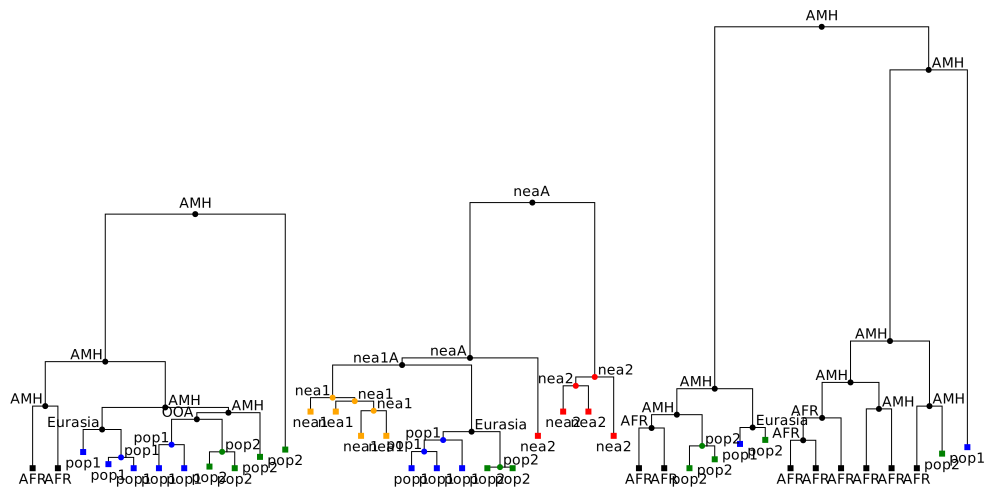

In [14]:
plot_tree(ts_small, ts_small.at(0), populations, node_labels=True)

Iterate over all trees and detect those which indicate Neanderthal introgression into Eurasians:

In [15]:
def get_introgressed_leaves(tree, neand_ids):
    start, end = tree.interval

    admixed_list = []
    for root in tree.roots:
        # is the current root rooted in a Neanderthal population?
        if tree.population(root) in neand_ids:
            # if it is, collect all non-Neanderthal nodes under this root
            # (these are Eurasians carrying Neanderthal introgression at this locus)
            admixed = [node for node in tree.leaves(root)
                       if not tree.population(node) in neand_ids]
            admixed_list.extend(admixed)

    return admixed_list

In [16]:
def detect_introgression(ts, neand_ids):
    result = []

    for tree in tqdm.notebook.tqdm_notebook(ts.trees()):
        leaves = get_introgressed_leaves(tree, neand_ids)
        start, end = tree.interval
        result.append((int(start), int(end), leaves))

    segments = pandas.DataFrame(result, columns=["start", "end", "node"]) \
        .explode("node") \
        .dropna() \
        .sort_values(by=["node", "start"]) \
        .reset_index(drop=True) \
    
    return segments

In [17]:
def merge_adjacent(segments):
    all_merged = []

    for node in tqdm.notebook.tqdm_notebook(segments.node.unique()):
        node_segments = []

        for i, seg in enumerate(segments.query(f"node == {node}").itertuples()):
            if i == 0: # initialize detection of continuous segments with the first segment
                segment_start, prev_end = seg.start, seg.end
            elif seg.start == prev_end: # the current segment starts where the previous ended -- continue
                prev_end = seg.end
            else: # end the continuous segment, start a new one
                node_segments.append((segment_start, prev_end, node))
                segment_start, prev_end = seg.start, seg.end

        # close the last remaining segment
        node_segments.append((segment_start, seg.end, node))

        all_merged.append(node_segments)

    all_merged = list(chain.from_iterable(all_merged))

    segments = pandas.DataFrame(all_merged, columns=["start", "end", "node"]) \
        .sort_values(by=["node", "start"]) \
        .reset_index(drop=True)

    return segments

In [18]:
populations

,pop,parent,N,tsplit_gen,tsplit_orig,tremove_gen,tremove_orig,pop_id,parent_id
0,archaic,ancestor,3000,1,550000,-1,-1,0,-1
1,AMH,ancestor,10000,1,550000,-1,-1,1,-1
2,neaA,archaic,1000,6898,350000,-1,-1,2,0
3,nea2,neaA,1000,14484,130000,18965,35,3,2
4,nea1A,neaA,1000,14484,130000,-1,-1,4,2
5,nea1,nea1A,1000,15863,90000,18965,35,5,4
6,intN,nea1A,1000,15863,90000,18965,35,6,4
7,OOA,AMH,2200,16725,65000,-1,-1,7,1
8,AFR,AMH,10000,16725,65000,-1,-1,8,1
9,Eurasia,OOA,5000,17035,56000,-1,-1,9,7


In [19]:
neand_ids = list(populations.query("pop in ['archaic', 'neaA', 'nea2', 'nea1A', 'nea1', 'intN']") .pop_id)
neand_ids

[0, 2, 3, 4, 5, 6]

In [20]:
segments = detect_introgression(ts, neand_ids=neand_ids)

  0%|          | 0/925740 [00:00<?, ?it/s]

In [21]:
len(segments.node.unique())

744

In [22]:
merged_segments = merge_adjacent(segments)

  0%|          | 0/744 [00:00<?, ?it/s]

In [23]:
len(merged_segments.node.unique())

744

## Plots of the "maps" of Neanderthal tracts in selected chromosomes

Let's make sure that the original segments and the merged adjacent segments are exactly the same:

In [24]:
def plot_segments(df, nodes, size, pdf=None):
    subset_segments = df.loc[df["node"].isin(nodes)]

    fig, ax = plt.subplots(figsize=size)

    ax.set_title("Positions of Neanderthal ancestry segments in a random pool of simulated EUR chromosomes")
    ax.set_ylabel("simulated EUR chromosome ID #")
    ax.set_xlabel("position along the chromosome [bp]")

    ax.set_ylim(1, len(nodes))
    ax.set_yticks(range(1, len(nodes) + 1))
    ax.set_yticklabels(nodes)

    positions = numpy.linspace(0, 100e6, 11)
    ax.set_xticks(positions)
    ax.set_xticklabels([f"{i/1e6}" for i in positions])

    for i, node in enumerate(nodes, start=1):
        node_segments = df.query(f"node == {node}")

        for segment in node_segments.itertuples():
            ax.hlines(y=i, xmin=segment.start, xmax=segment.end, linewidth=10, color='b')
        neand_proportion = (node_segments.end - node_segments.start).sum()/100e6

        print(f"True archaic ancestry on EUR chromosome ID #{node}: {100 * neand_proportion:.3f}%")

    plt.show()

    if pdf: fig.savefig(pdf)

In [25]:
subset_nodes = sorted(random.sample(list(segments.node.unique()), 20))

True archaic ancestry on EUR chromosome ID #605: 2.781%
True archaic ancestry on EUR chromosome ID #616: 3.376%
True archaic ancestry on EUR chromosome ID #785: 2.645%
True archaic ancestry on EUR chromosome ID #821: 2.764%
True archaic ancestry on EUR chromosome ID #899: 3.498%
True archaic ancestry on EUR chromosome ID #940: 2.988%
True archaic ancestry on EUR chromosome ID #951: 3.483%
True archaic ancestry on EUR chromosome ID #978: 2.512%
True archaic ancestry on EUR chromosome ID #1024: 4.070%
True archaic ancestry on EUR chromosome ID #1088: 4.829%
True archaic ancestry on EUR chromosome ID #1100: 2.578%
True archaic ancestry on EUR chromosome ID #1135: 2.045%
True archaic ancestry on EUR chromosome ID #1145: 3.248%
True archaic ancestry on EUR chromosome ID #1177: 3.772%
True archaic ancestry on EUR chromosome ID #1201: 2.891%
True archaic ancestry on EUR chromosome ID #1208: 2.672%
True archaic ancestry on EUR chromosome ID #1260: 2.702%
True archaic ancestry on EUR chromosome

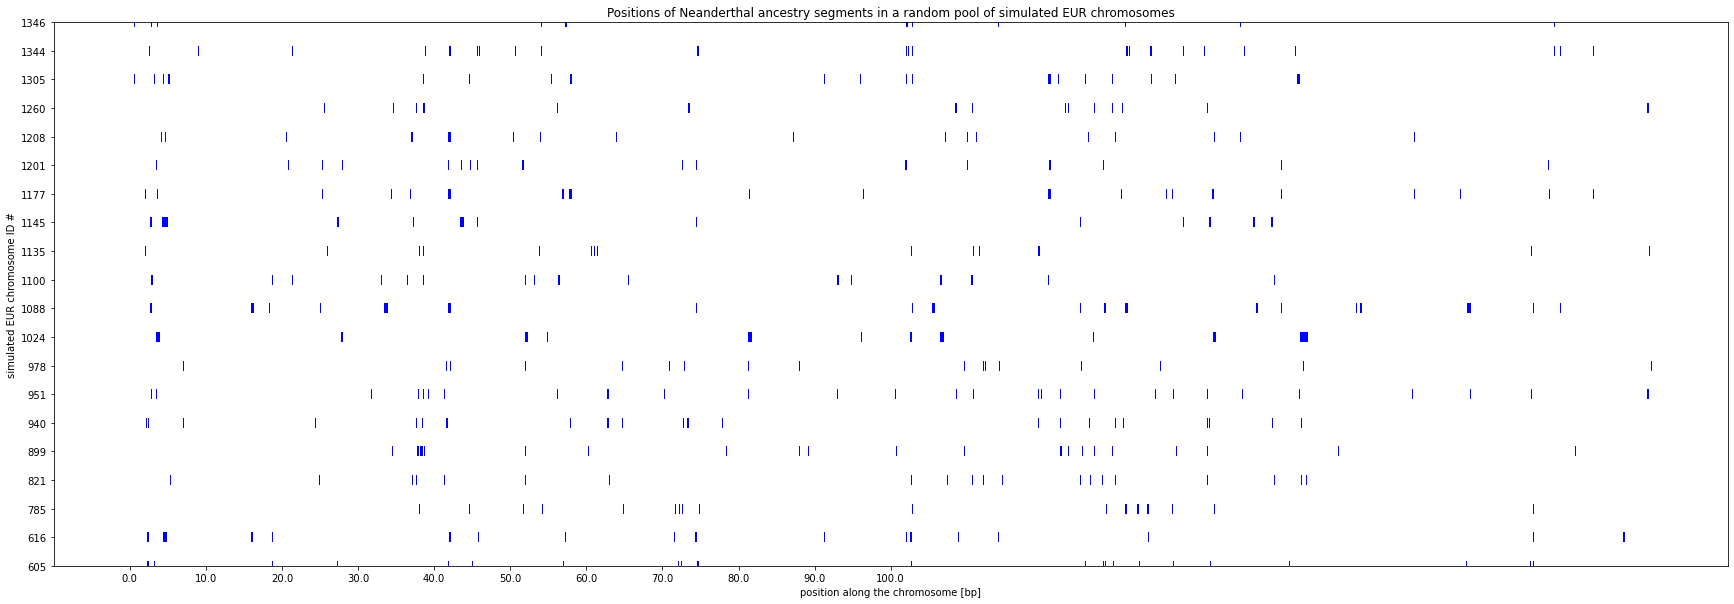

In [26]:
plot_segments(segments, nodes=subset_nodes, size=(30, 10))

True archaic ancestry on EUR chromosome ID #605: 2.781%
True archaic ancestry on EUR chromosome ID #616: 3.376%
True archaic ancestry on EUR chromosome ID #785: 2.645%
True archaic ancestry on EUR chromosome ID #821: 2.764%
True archaic ancestry on EUR chromosome ID #899: 3.498%
True archaic ancestry on EUR chromosome ID #940: 2.988%
True archaic ancestry on EUR chromosome ID #951: 3.483%
True archaic ancestry on EUR chromosome ID #978: 2.512%
True archaic ancestry on EUR chromosome ID #1024: 4.070%
True archaic ancestry on EUR chromosome ID #1088: 4.829%
True archaic ancestry on EUR chromosome ID #1100: 2.578%
True archaic ancestry on EUR chromosome ID #1135: 2.045%
True archaic ancestry on EUR chromosome ID #1145: 3.248%
True archaic ancestry on EUR chromosome ID #1177: 3.772%
True archaic ancestry on EUR chromosome ID #1201: 2.891%
True archaic ancestry on EUR chromosome ID #1208: 2.672%
True archaic ancestry on EUR chromosome ID #1260: 2.702%
True archaic ancestry on EUR chromosome

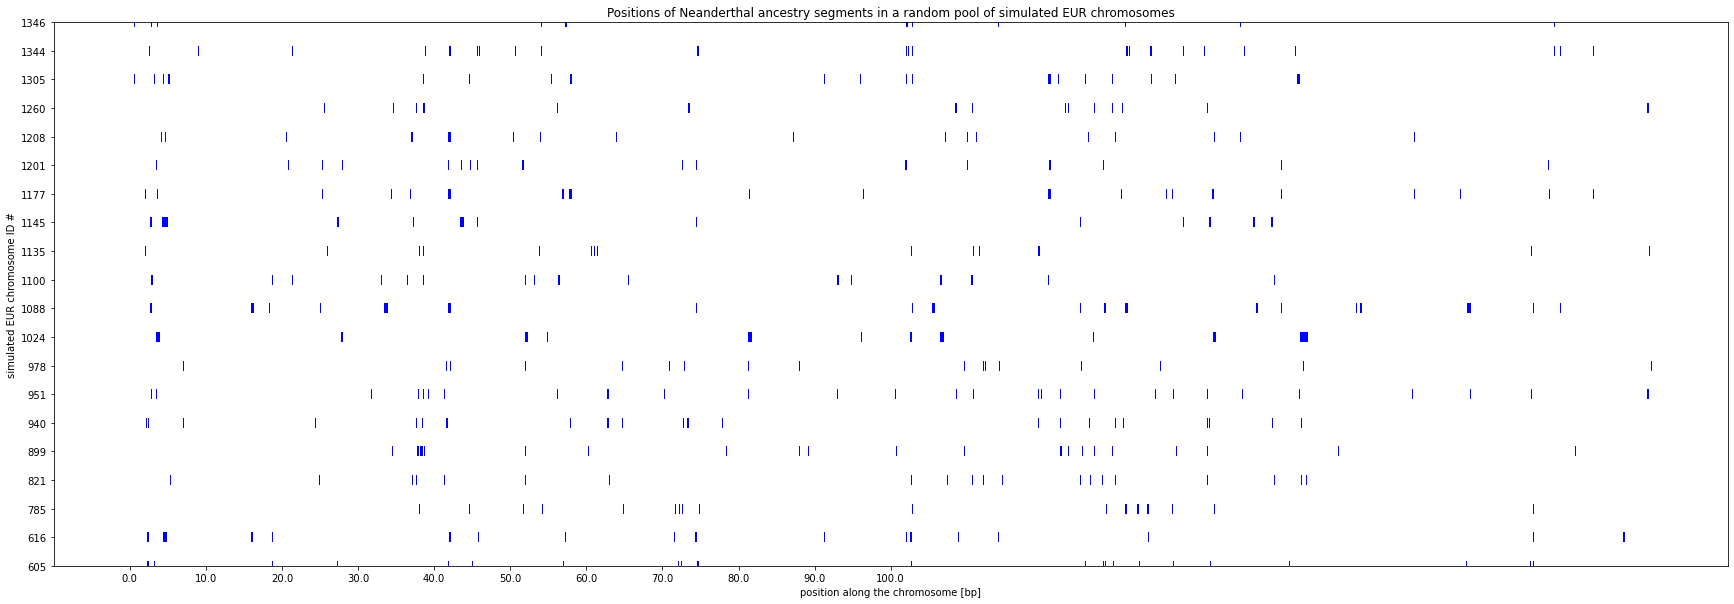

In [27]:
plot_segments(merged_segments, nodes=subset_nodes, size=(30, 10))

## Save output

Before we can save the table of Neanderthal tracts, we need to assign to each node/chromosome its unique numeric SLiM id. We will need this to be able to trace those tracts for each chromosome back to the easy to read individual names we have in *slendr*:

In [37]:
merged_segments["slim_id"] = pandas.Series(ts.node(i).metadata["slim_id"] for i in merged_segments.node)

Finally, we will save the coordinates of introgressed tracts in the simulated European chromosomes in a BED-like format:

In [38]:
merged_segments[["start", "end", "slim_id"]].to_csv("results/tracts_v2.tsv.gz", sep="\t", index=False)